In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import subprocess

In [6]:
x_pixels = 1078
y_pixels = 1078

data = pd.read_csv('200.csv', header=None)

oops, it looks like I forgot that ghost cells eat 2 collumns and rows of cells when I set my simulation parameters. I wanted 1080x1080 but 1078x1078 is fine, it's not worth running the simulation for another 10 hours to fix

### Find max and min density values

The max and min values are needed for the sake of scaling the color representation of density the same between all frames

In [4]:
def find_min_max_in_folder(folder_path):
    min_value = float('inf')
    max_value = float('-inf')

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            
            numerical_values = df.select_dtypes(include='number')
            
            if not numerical_values.empty:
                file_min = numerical_values.min().min()
                file_max = numerical_values.max().max()
                
                if file_min < min_value:
                    min_value = file_min
                if file_max > max_value:
                    max_value = file_max

    return min_value, max_value

folder_path = r'FILL_IN'
min_value, max_value = find_min_max_in_folder(folder_path)
print(f"The minimum value across all CSV files is: {min_value}")
print(f"The maximum value across all CSV files is: {max_value}")


The minimum value across all CSV files is: 0.0646181
The maximum value across all CSV files is: 4.93327


### Define custom colormap

Density values range from 0 to 5. The majority of the density values range from around 1 to 4 at the start of the simulation so I want to more contrast within that range. Only showing values from 1 to 4 decreases resolution too much at the end of the animation. At the end, there are interesting swirl features created by the cells with density values less than 1 that I want to capture. Considering this, I chose to define a non-linear color map based on a sigmoid function for my animation.

In [5]:
def sigmoid(x, power=2):
    return x**power / (x**power + (1 - x)**power)

def sigmoid_colormap(n_points, power=2):
    x = np.linspace(0, 1, n_points)
    return sigmoid(x, power)

cmap = plt.get_cmap('viridis')
n_points = 256
power = 2
nonlinear_indices = sigmoid_colormap(n_points, power)  # increase power to make the ends change slower and the middle faster
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap(nonlinear_indices))

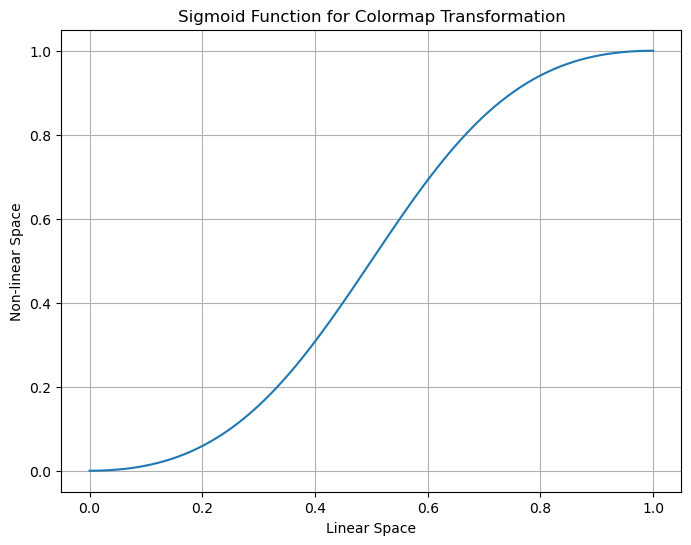

In [6]:
x = np.linspace(0, 1, 256)
y = sigmoid(x, power)
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.xlabel('Linear Space')
plt.ylabel('Non-linear Space')
plt.title('Sigmoid Function for Colormap Transformation')
plt.grid(True)
plt.show()

### Frame of animation

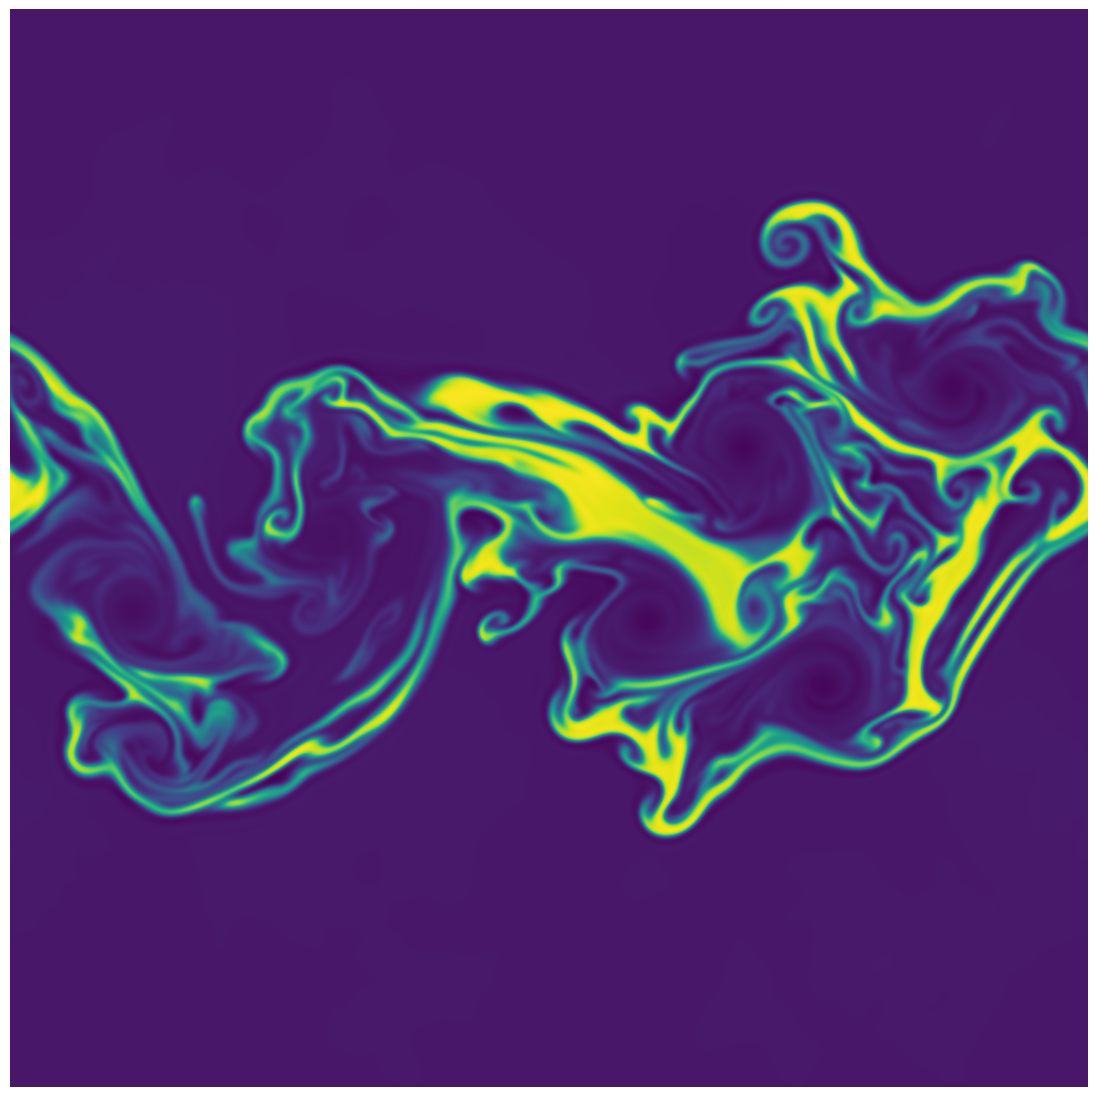

In [7]:
DPI = 100
width_inch = x_pixels / DPI
height_inch = y_pixels / DPI
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=DPI)
ax.axis('off')
X = np.linspace(0, 1, x_pixels)
Y = np.linspace(0, 1, y_pixels)
c = ax.pcolormesh(X, Y, data, cmap=custom_cmap, shading='auto', vmin=0, vmax=max_value)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.show()

### Produce frames

My computer didn't like running this block to save images 0 through 1000 in one go. I used the range 0 to 500 then 500 to 1000. Since I'm not doing anything fancy with this animation, it probably would have been easier to not save all the images and just make the animation

In [ ]:
def load_data(filepath):
    return np.loadtxt(filepath, delimiter=',', usecols=range(x_pixels))

def save_frame(data, frame_number, output_dir):
    DPI = 100
    width_inch = x_pixels / DPI
    height_inch = y_pixels / DPI
    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=DPI)
    ax.axis('off')
    X = np.linspace(0, 1, x_pixels)
    Y = np.linspace(0, 1, y_pixels)
    c = ax.pcolormesh(X, Y, data, cmap=custom_cmap, shading='auto', vmin=0, vmax=max_value)
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    
    filename = f'frame_{frame_number:04d}.png'
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=DPI, pad_inches=0, transparent=True, format='png')
    plt.close(fig)

csv_dir = r'FILL_IN'
output_dir = r'FILL_IN'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(0, 1000):
    filename = f'{i}.csv'
    filepath = os.path.join(csv_dir, filename)
    data = load_data(filepath)
    save_frame(data, i, output_dir)

print(f'Saved frames to {output_dir}')

### Produce animation

In [ ]:
frames_dir = r'FILL_IN'
output_video_path = r'FILL_IN' # include video name at the ends of the path

fps = 30 

ffmpeg_command = [
    'ffmpeg',
    '-framerate', str(fps),
    '-i', os.path.join(frames_dir, 'frame_%04d.png'),  
    '-c:v', 'libx265',
    '-preset', 'veryslow',
    '-crf', '0', # lower constant rate factor should be better quality
    '-pix_fmt', 'yuv444p', # pixel format is interesting
    '-vf', 'scale=1080:1080',
    output_video_path
]

subprocess.run(ffmpeg_command, check=True)

print(f'Video saved to {output_video_path}')